<a href="https://colab.research.google.com/github/Raghunandan1234/Image_Caption_Detector/blob/main/Image_Caption_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import tensorflow
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [ ]:
BASE_DIR = './flickr8k'
WORKING_DIR = './flickr8k'
IMG_DIR = './flickr8k/images/'
CAP_DIR = './flickr8k/captions.txt'

In [ ]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(IMG_DIR)):
    # load the image from file
    img_path = IMG_DIR + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

In [ ]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [ ]:
# load features from pickle
with open(os.path.join(BASE_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [ ]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [ ]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

In [ ]:
len(mapping)

8091

In [ ]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc.,
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in         caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [ ]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [ ]:
# preprocess the text
clean(mapping)

In [ ]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [ ]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [ ]:
len(all_captions)

40455

In [ ]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [ ]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
vocab_size

8485

In [ ]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [ ]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [ ]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq],
                       num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [ ]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [ ]:
# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 227 steps
227/227 [==============================] - ETA: 42:36 - loss: 9.10 - ETA: 29:32 - loss: 8.90 - ETA: 22:23 - loss: 8.60 - ETA: 18:53 - loss: 8.18 - ETA: 16:44 - loss: 7.91 - ETA: 15:12 - loss: 7.63 - ETA: 14:12 - loss: 7.44 - ETA: 13:25 - loss: 7.30 - ETA: 12:51 - loss: 7.20 - ETA: 12:24 - loss: 7.11 - ETA: 12:02 - loss: 7.01 - ETA: 11:42 - loss: 6.94 - ETA: 11:23 - loss: 6.89 - ETA: 11:07 - loss: 6.84 - ETA: 10:50 - loss: 6.79 - ETA: 10:37 - loss: 6.75 - ETA: 10:24 - loss: 6.71 - ETA: 10:15 - loss: 6.65 - ETA: 10:06 - loss: 6.62 - ETA: 9:56 - loss: 6.6018 - ETA: 9:48 - loss: 6.567 - ETA: 9:38 - loss: 6.530 - ETA: 9:31 - loss: 6.504 - ETA: 9:26 - loss: 6.482 - ETA: 9:23 - loss: 6.455 - ETA: 9:16 - loss: 6.439 - ETA: 9:10 - loss: 6.425 - ETA: 9:04 - loss: 6.403 - ETA: 8:59 - loss: 6.382 - ETA: 8:53 - loss: 6.364 - ETA: 8:49 - loss: 6.348 - ETA: 8:44 - loss: 6.326 - ETA: 8:38 - loss: 6.306 - ETA: 8:34 - loss: 6.292 - ETA: 8:30 - loss: 6.271 - ETA: 8:25 - loss: 6.256 - 

  ...
    to  
  ['...']


Train for 227 steps
227/227 [==============================] - ETA: 10:18 - loss: 4.14 - ETA: 9:32 - loss: 4.2211 - ETA: 9:02 - loss: 4.265 - ETA: 8:52 - loss: 4.219 - ETA: 8:49 - loss: 4.265 - ETA: 8:45 - loss: 4.265 - ETA: 8:43 - loss: 4.261 - ETA: 8:38 - loss: 4.274 - ETA: 8:36 - loss: 4.288 - ETA: 8:34 - loss: 4.309 - ETA: 8:30 - loss: 4.300 - ETA: 8:30 - loss: 4.314 - ETA: 8:28 - loss: 4.319 - ETA: 8:26 - loss: 4.329 - ETA: 8:21 - loss: 4.326 - ETA: 8:17 - loss: 4.335 - ETA: 8:13 - loss: 4.335 - ETA: 8:10 - loss: 4.316 - ETA: 8:09 - loss: 4.327 - ETA: 8:06 - loss: 4.329 - ETA: 8:02 - loss: 4.320 - ETA: 7:58 - loss: 4.313 - ETA: 7:56 - loss: 4.323 - ETA: 7:54 - loss: 4.327 - ETA: 7:50 - loss: 4.325 - ETA: 7:48 - loss: 4.338 - ETA: 7:46 - loss: 4.344 - ETA: 7:43 - loss: 4.339 - ETA: 7:41 - loss: 4.334 - ETA: 7:39 - loss: 4.332 - ETA: 7:36 - loss: 4.334 - ETA: 7:33 - loss: 4.326 - ETA: 7:31 - loss: 4.321 - ETA: 7:29 - loss: 4.321 - ETA: 7:27 - loss: 4.313 - ETA: 7:24 - loss: 4.310 - 

  ...
    to  
  ['...']


Train for 227 steps
227/227 [==============================] - ETA: 10:30 - loss: 3.52 - ETA: 9:48 - loss: 3.6066 - ETA: 9:21 - loss: 3.637 - ETA: 9:04 - loss: 3.602 - ETA: 8:57 - loss: 3.651 - ETA: 8:45 - loss: 3.644 - ETA: 8:42 - loss: 3.647 - ETA: 8:37 - loss: 3.662 - ETA: 8:39 - loss: 3.675 - ETA: 8:38 - loss: 3.696 - ETA: 8:33 - loss: 3.688 - ETA: 8:30 - loss: 3.699 - ETA: 8:27 - loss: 3.706 - ETA: 8:24 - loss: 3.719 - ETA: 8:19 - loss: 3.713 - ETA: 8:17 - loss: 3.717 - ETA: 8:14 - loss: 3.716 - ETA: 8:10 - loss: 3.703 - ETA: 8:07 - loss: 3.717 - ETA: 8:03 - loss: 3.721 - ETA: 8:00 - loss: 3.714 - ETA: 7:55 - loss: 3.708 - ETA: 7:54 - loss: 3.720 - ETA: 7:53 - loss: 3.726 - ETA: 7:49 - loss: 3.726 - ETA: 7:46 - loss: 3.740 - ETA: 7:44 - loss: 3.748 - ETA: 7:41 - loss: 3.746 - ETA: 7:39 - loss: 3.742 - ETA: 7:37 - loss: 3.743 - ETA: 7:35 - loss: 3.748 - ETA: 7:32 - loss: 3.743 - ETA: 7:29 - loss: 3.740 - ETA: 7:27 - loss: 3.742 - ETA: 7:25 - loss: 3.736 - ETA: 7:22 - loss: 3.734 - 

  ...
    to  
  ['...']


Train for 227 steps
227/227 [==============================] - ETA: 9:50 - loss: 3.227 - ETA: 9:15 - loss: 3.302 - ETA: 8:51 - loss: 3.321 - ETA: 8:51 - loss: 3.298 - ETA: 8:52 - loss: 3.348 - ETA: 8:41 - loss: 3.338 - ETA: 8:39 - loss: 3.343 - ETA: 8:35 - loss: 3.359 - ETA: 8:33 - loss: 3.370 - ETA: 8:33 - loss: 3.392 - ETA: 8:30 - loss: 3.384 - ETA: 8:28 - loss: 3.393 - ETA: 8:25 - loss: 3.399 - ETA: 8:22 - loss: 3.409 - ETA: 8:17 - loss: 3.401 - ETA: 8:14 - loss: 3.399 - ETA: 8:10 - loss: 3.394 - ETA: 8:08 - loss: 3.381 - ETA: 8:06 - loss: 3.392 - ETA: 8:02 - loss: 3.394 - ETA: 7:59 - loss: 3.386 - ETA: 7:54 - loss: 3.380 - ETA: 7:52 - loss: 3.392 - ETA: 7:51 - loss: 3.398 - ETA: 7:48 - loss: 3.397 - ETA: 7:46 - loss: 3.412 - ETA: 7:43 - loss: 3.420 - ETA: 7:41 - loss: 3.420 - ETA: 7:38 - loss: 3.416 - ETA: 7:36 - loss: 3.419 - ETA: 7:34 - loss: 3.424 - ETA: 7:32 - loss: 3.421 - ETA: 7:29 - loss: 3.418 - ETA: 7:27 - loss: 3.421 - ETA: 7:25 - loss: 3.416 - ETA: 7:23 - loss: 3.414 - E

  ...
    to  
  ['...']


Train for 227 steps
227/227 [==============================] - ETA: 10:31 - loss: 3.03 - ETA: 9:41 - loss: 3.0917 - ETA: 9:08 - loss: 3.104 - ETA: 8:57 - loss: 3.085 - ETA: 8:54 - loss: 3.135 - ETA: 8:42 - loss: 3.117 - ETA: 8:43 - loss: 3.119 - ETA: 8:43 - loss: 3.138 - ETA: 8:40 - loss: 3.152 - ETA: 8:37 - loss: 3.170 - ETA: 8:32 - loss: 3.163 - ETA: 8:32 - loss: 3.172 - ETA: 8:31 - loss: 3.181 - ETA: 8:31 - loss: 3.193 - ETA: 8:27 - loss: 3.183 - ETA: 8:23 - loss: 3.179 - ETA: 8:20 - loss: 3.171 - ETA: 8:16 - loss: 3.159 - ETA: 8:14 - loss: 3.167 - ETA: 8:11 - loss: 3.168 - ETA: 8:09 - loss: 3.159 - ETA: 8:04 - loss: 3.152 - ETA: 8:02 - loss: 3.162 - ETA: 8:00 - loss: 3.168 - ETA: 7:57 - loss: 3.165 - ETA: 7:54 - loss: 3.179 - ETA: 7:52 - loss: 3.186 - ETA: 7:50 - loss: 3.187 - ETA: 7:48 - loss: 3.182 - ETA: 7:45 - loss: 3.185 - ETA: 7:44 - loss: 3.190 - ETA: 7:41 - loss: 3.187 - ETA: 7:37 - loss: 3.184 - ETA: 7:35 - loss: 3.187 - ETA: 7:34 - loss: 3.183 - ETA: 7:32 - loss: 3.183 - 

  ...
    to  
  ['...']


Train for 227 steps
227/227 [==============================] - ETA: 9:49 - loss: 2.911 - ETA: 9:30 - loss: 2.954 - ETA: 9:09 - loss: 2.959 - ETA: 9:06 - loss: 2.935 - ETA: 8:57 - loss: 2.986 - ETA: 8:45 - loss: 2.969 - ETA: 8:44 - loss: 2.971 - ETA: 8:40 - loss: 2.990 - ETA: 8:37 - loss: 2.999 - ETA: 8:39 - loss: 3.012 - ETA: 8:35 - loss: 3.003 - ETA: 8:32 - loss: 3.010 - ETA: 8:29 - loss: 3.021 - ETA: 8:25 - loss: 3.032 - ETA: 8:20 - loss: 3.023 - ETA: 8:15 - loss: 3.017 - ETA: 8:13 - loss: 3.010 - ETA: 8:10 - loss: 2.999 - ETA: 8:08 - loss: 3.006 - ETA: 8:04 - loss: 3.008 - ETA: 8:00 - loss: 2.998 - ETA: 7:55 - loss: 2.991 - ETA: 7:53 - loss: 3.000 - ETA: 7:52 - loss: 3.006 - ETA: 7:50 - loss: 3.002 - ETA: 7:47 - loss: 3.015 - ETA: 7:45 - loss: 3.021 - ETA: 7:42 - loss: 3.022 - ETA: 7:39 - loss: 3.018 - ETA: 7:37 - loss: 3.020 - ETA: 7:35 - loss: 3.025 - ETA: 7:33 - loss: 3.023 - ETA: 7:30 - loss: 3.019 - ETA: 7:28 - loss: 3.022 - ETA: 7:25 - loss: 3.017 - ETA: 7:23 - loss: 3.018 - E

  ...
    to  
  ['...']


Train for 227 steps
227/227 [==============================] - ETA: 10:29 - loss: 2.80 - ETA: 9:33 - loss: 2.8463 - ETA: 9:02 - loss: 2.849 - ETA: 8:51 - loss: 2.825 - ETA: 8:45 - loss: 2.876 - ETA: 8:35 - loss: 2.861 - ETA: 8:36 - loss: 2.860 - ETA: 8:35 - loss: 2.878 - ETA: 8:33 - loss: 2.889 - ETA: 8:31 - loss: 2.902 - ETA: 8:26 - loss: 2.893 - ETA: 8:24 - loss: 2.900 - ETA: 8:23 - loss: 2.908 - ETA: 8:21 - loss: 2.917 - ETA: 8:19 - loss: 2.906 - ETA: 8:16 - loss: 2.902 - ETA: 8:14 - loss: 2.893 - ETA: 8:12 - loss: 2.883 - ETA: 8:11 - loss: 2.891 - ETA: 8:06 - loss: 2.894 - ETA: 8:04 - loss: 2.885 - ETA: 8:00 - loss: 2.879 - ETA: 7:57 - loss: 2.889 - ETA: 7:55 - loss: 2.893 - ETA: 7:52 - loss: 2.888 - ETA: 7:48 - loss: 2.898 - ETA: 7:46 - loss: 2.902 - ETA: 7:44 - loss: 2.902 - ETA: 7:42 - loss: 2.898 - ETA: 7:39 - loss: 2.899 - ETA: 7:37 - loss: 2.904 - ETA: 7:34 - loss: 2.902 - ETA: 7:31 - loss: 2.898 - ETA: 7:29 - loss: 2.902 - ETA: 7:28 - loss: 2.898 - ETA: 7:26 - loss: 2.899 - 

  ...
    to  
  ['...']


Train for 227 steps
227/227 [==============================] - ETA: 9:46 - loss: 2.685 - ETA: 9:16 - loss: 2.740 - ETA: 9:06 - loss: 2.729 - ETA: 9:10 - loss: 2.709 - ETA: 9:02 - loss: 2.764 - ETA: 8:50 - loss: 2.749 - ETA: 8:47 - loss: 2.750 - ETA: 8:42 - loss: 2.771 - ETA: 8:40 - loss: 2.784 - ETA: 8:42 - loss: 2.797 - ETA: 8:35 - loss: 2.792 - ETA: 8:32 - loss: 2.802 - ETA: 8:29 - loss: 2.812 - ETA: 8:26 - loss: 2.820 - ETA: 8:21 - loss: 2.814 - ETA: 8:18 - loss: 2.809 - ETA: 8:15 - loss: 2.802 - ETA: 8:11 - loss: 2.793 - ETA: 8:08 - loss: 2.800 - ETA: 8:04 - loss: 2.804 - ETA: 8:01 - loss: 2.796 - ETA: 7:56 - loss: 2.790 - ETA: 7:55 - loss: 2.799 - ETA: 7:55 - loss: 2.802 - ETA: 7:51 - loss: 2.795 - ETA: 7:48 - loss: 2.804 - ETA: 7:46 - loss: 2.808 - ETA: 7:43 - loss: 2.807 - ETA: 7:41 - loss: 2.801 - ETA: 7:38 - loss: 2.801 - ETA: 7:37 - loss: 2.803 - ETA: 7:34 - loss: 2.800 - ETA: 7:31 - loss: 2.797 - ETA: 7:28 - loss: 2.798 - ETA: 7:26 - loss: 2.796 - ETA: 7:24 - loss: 2.797 - E

  ...
    to  
  ['...']


Train for 227 steps
227/227 [==============================] - ETA: 10:14 - loss: 2.57 - ETA: 9:45 - loss: 2.6495 - ETA: 9:08 - loss: 2.637 - ETA: 8:55 - loss: 2.626 - ETA: 8:48 - loss: 2.672 - ETA: 8:39 - loss: 2.660 - ETA: 8:43 - loss: 2.662 - ETA: 8:40 - loss: 2.676 - ETA: 8:37 - loss: 2.688 - ETA: 8:35 - loss: 2.699 - ETA: 8:29 - loss: 2.693 - ETA: 8:26 - loss: 2.705 - ETA: 8:24 - loss: 2.716 - ETA: 8:24 - loss: 2.722 - ETA: 8:19 - loss: 2.716 - ETA: 8:14 - loss: 2.711 - ETA: 8:10 - loss: 2.704 - ETA: 8:06 - loss: 2.697 - ETA: 8:04 - loss: 2.706 - ETA: 8:00 - loss: 2.708 - ETA: 7:59 - loss: 2.702 - ETA: 7:55 - loss: 2.696 - ETA: 7:53 - loss: 2.707 - ETA: 7:51 - loss: 2.711 - ETA: 7:48 - loss: 2.707 - ETA: 7:44 - loss: 2.716 - ETA: 7:42 - loss: 2.720 - ETA: 7:41 - loss: 2.719 - ETA: 7:38 - loss: 2.714 - ETA: 7:36 - loss: 2.715 - ETA: 7:34 - loss: 2.716 - ETA: 7:31 - loss: 2.715 - ETA: 7:28 - loss: 2.710 - ETA: 7:25 - loss: 2.711 - ETA: 7:25 - loss: 2.709 - ETA: 7:22 - loss: 2.711 - 

  ...
    to  
  ['...']


Train for 227 steps
227/227 [==============================] - ETA: 10:15 - loss: 2.52 - ETA: 9:24 - loss: 2.5895 - ETA: 8:57 - loss: 2.566 - ETA: 8:52 - loss: 2.551 - ETA: 8:51 - loss: 2.596 - ETA: 8:41 - loss: 2.582 - ETA: 8:40 - loss: 2.584 - ETA: 8:37 - loss: 2.601 - ETA: 8:36 - loss: 2.610 - ETA: 8:35 - loss: 2.620 - ETA: 8:31 - loss: 2.612 - ETA: 8:30 - loss: 2.623 - ETA: 8:27 - loss: 2.633 - ETA: 8:24 - loss: 2.641 - ETA: 8:19 - loss: 2.636 - ETA: 8:15 - loss: 2.630 - ETA: 8:11 - loss: 2.624 - ETA: 8:09 - loss: 2.617 - ETA: 8:07 - loss: 2.626 - ETA: 8:03 - loss: 2.628 - ETA: 8:00 - loss: 2.622 - ETA: 7:55 - loss: 2.617 - ETA: 7:53 - loss: 2.628 - ETA: 7:52 - loss: 2.632 - ETA: 7:50 - loss: 2.627 - ETA: 7:53 - loss: 2.639 - ETA: 7:53 - loss: 2.641 - ETA: 7:53 - loss: 2.640 - ETA: 7:53 - loss: 2.636 - ETA: 7:55 - loss: 2.637 - ETA: 7:54 - loss: 2.639 - ETA: 7:52 - loss: 2.637 - ETA: 7:49 - loss: 2.633 - ETA: 7:47 - loss: 2.633 - ETA: 7:45 - loss: 2.631 - ETA: 7:42 - loss: 2.633 - 

  ...
    to  
  ['...']


Train for 227 steps
227/227 [==============================] - ETA: 9:42 - loss: 2.485 - ETA: 9:03 - loss: 2.533 - ETA: 8:40 - loss: 2.525 - ETA: 8:38 - loss: 2.507 - ETA: 8:35 - loss: 2.553 - ETA: 8:35 - loss: 2.533 - ETA: 8:35 - loss: 2.534 - ETA: 8:31 - loss: 2.553 - ETA: 8:29 - loss: 2.561 - ETA: 8:29 - loss: 2.568 - ETA: 8:24 - loss: 2.559 - ETA: 8:23 - loss: 2.566 - ETA: 8:24 - loss: 2.576 - ETA: 8:21 - loss: 2.583 - ETA: 8:15 - loss: 2.578 - ETA: 8:12 - loss: 2.571 - ETA: 8:08 - loss: 2.565 - ETA: 8:04 - loss: 2.558 - ETA: 8:03 - loss: 2.566 - ETA: 8:01 - loss: 2.568 - ETA: 7:57 - loss: 2.561 - ETA: 7:53 - loss: 2.555 - ETA: 7:51 - loss: 2.565 - ETA: 7:49 - loss: 2.567 - ETA: 7:46 - loss: 2.563 - ETA: 7:43 - loss: 2.572 - ETA: 7:42 - loss: 2.575 - ETA: 7:39 - loss: 2.575 - ETA: 7:37 - loss: 2.570 - ETA: 7:34 - loss: 2.569 - ETA: 7:32 - loss: 2.573 - ETA: 7:29 - loss: 2.572 - ETA: 7:27 - loss: 2.568 - ETA: 7:26 - loss: 2.569 - ETA: 7:25 - loss: 2.565 - ETA: 7:23 - loss: 2.566 - E

  ...
    to  
  ['...']


Train for 227 steps
227/227 [==============================] - ETA: 9:54 - loss: 2.423 - ETA: 9:23 - loss: 2.473 - ETA: 9:05 - loss: 2.457 - ETA: 8:54 - loss: 2.441 - ETA: 8:46 - loss: 2.486 - ETA: 8:36 - loss: 2.467 - ETA: 8:35 - loss: 2.470 - ETA: 8:31 - loss: 2.489 - ETA: 8:32 - loss: 2.496 - ETA: 8:33 - loss: 2.507 - ETA: 8:28 - loss: 2.497 - ETA: 8:24 - loss: 2.503 - ETA: 8:22 - loss: 2.510 - ETA: 8:20 - loss: 2.514 - ETA: 8:15 - loss: 2.509 - ETA: 8:12 - loss: 2.503 - ETA: 8:10 - loss: 2.496 - ETA: 8:06 - loss: 2.491 - ETA: 8:04 - loss: 2.498 - ETA: 8:00 - loss: 2.500 - ETA: 7:56 - loss: 2.494 - ETA: 7:52 - loss: 2.490 - ETA: 7:51 - loss: 2.499 - ETA: 7:51 - loss: 2.502 - ETA: 7:47 - loss: 2.498 - ETA: 7:44 - loss: 2.507 - ETA: 7:42 - loss: 2.509 - ETA: 7:39 - loss: 2.510 - ETA: 7:37 - loss: 2.505 - ETA: 7:35 - loss: 2.505 - ETA: 7:33 - loss: 2.507 - ETA: 7:30 - loss: 2.506 - ETA: 7:27 - loss: 2.503 - ETA: 7:24 - loss: 2.503 - ETA: 7:22 - loss: 2.501 - ETA: 7:20 - loss: 2.502 - E

  ...
    to  
  ['...']


Train for 227 steps
227/227 [==============================] - ETA: 10:47 - loss: 2.38 - ETA: 9:38 - loss: 2.4137 - ETA: 9:06 - loss: 2.418 - ETA: 8:54 - loss: 2.399 - ETA: 8:47 - loss: 2.444 - ETA: 8:37 - loss: 2.421 - ETA: 8:39 - loss: 2.420 - ETA: 8:38 - loss: 2.438 - ETA: 8:37 - loss: 2.442 - ETA: 8:35 - loss: 2.452 - ETA: 8:35 - loss: 2.442 - ETA: 8:38 - loss: 2.450 - ETA: 8:37 - loss: 2.457 - ETA: 8:37 - loss: 2.460 - ETA: 8:33 - loss: 2.454 - ETA: 8:30 - loss: 2.448 - ETA: 8:27 - loss: 2.443 - ETA: 8:23 - loss: 2.438 - ETA: 8:23 - loss: 2.445 - ETA: 8:20 - loss: 2.447 - ETA: 8:19 - loss: 2.440 - ETA: 8:13 - loss: 2.436 - ETA: 8:10 - loss: 2.446 - ETA: 8:07 - loss: 2.450 - ETA: 8:03 - loss: 2.446 - ETA: 8:00 - loss: 2.454 - ETA: 7:57 - loss: 2.455 - ETA: 7:55 - loss: 2.455 - ETA: 7:52 - loss: 2.450 - ETA: 7:49 - loss: 2.451 - ETA: 7:46 - loss: 2.452 - ETA: 7:42 - loss: 2.452 - ETA: 7:39 - loss: 2.448 - ETA: 7:37 - loss: 2.449 - ETA: 7:35 - loss: 2.447 - ETA: 7:32 - loss: 2.449 - 

  ...
    to  
  ['...']


Train for 227 steps
227/227 [==============================] - ETA: 10:27 - loss: 2.33 - ETA: 9:41 - loss: 2.3780 - ETA: 9:24 - loss: 2.359 - ETA: 9:12 - loss: 2.344 - ETA: 9:01 - loss: 2.384 - ETA: 8:48 - loss: 2.368 - ETA: 8:47 - loss: 2.370 - ETA: 8:45 - loss: 2.386 - ETA: 8:45 - loss: 2.395 - ETA: 8:47 - loss: 2.400 - ETA: 8:45 - loss: 2.393 - ETA: 8:43 - loss: 2.403 - ETA: 8:39 - loss: 2.408 - ETA: 8:35 - loss: 2.412 - ETA: 8:29 - loss: 2.406 - ETA: 8:25 - loss: 2.398 - ETA: 8:22 - loss: 2.393 - ETA: 8:18 - loss: 2.387 - ETA: 8:15 - loss: 2.392 - ETA: 8:10 - loss: 2.395 - ETA: 8:06 - loss: 2.390 - ETA: 8:01 - loss: 2.386 - ETA: 7:59 - loss: 2.396 - ETA: 7:58 - loss: 2.400 - ETA: 7:54 - loss: 2.396 - ETA: 7:51 - loss: 2.405 - ETA: 7:48 - loss: 2.405 - ETA: 7:45 - loss: 2.405 - ETA: 7:42 - loss: 2.401 - ETA: 7:39 - loss: 2.401 - ETA: 7:38 - loss: 2.403 - ETA: 7:35 - loss: 2.402 - ETA: 7:32 - loss: 2.398 - ETA: 7:30 - loss: 2.397 - ETA: 7:29 - loss: 2.395 - ETA: 7:27 - loss: 2.397 - 

  ...
    to  
  ['...']


Train for 227 steps
227/227 [==============================] - ETA: 10:37 - loss: 2.29 - ETA: 9:48 - loss: 2.3372 - ETA: 9:12 - loss: 2.326 - ETA: 8:59 - loss: 2.304 - ETA: 8:49 - loss: 2.343 - ETA: 8:37 - loss: 2.332 - ETA: 8:37 - loss: 2.335 - ETA: 8:36 - loss: 2.350 - ETA: 8:35 - loss: 2.360 - ETA: 8:33 - loss: 2.367 - ETA: 8:27 - loss: 2.360 - ETA: 8:24 - loss: 2.366 - ETA: 8:22 - loss: 2.371 - ETA: 8:19 - loss: 2.374 - ETA: 8:16 - loss: 2.369 - ETA: 8:12 - loss: 2.362 - ETA: 8:08 - loss: 2.355 - ETA: 8:05 - loss: 2.347 - ETA: 8:04 - loss: 2.352 - ETA: 8:00 - loss: 2.357 - ETA: 7:57 - loss: 2.352 - ETA: 7:53 - loss: 2.347 - ETA: 7:52 - loss: 2.358 - ETA: 7:50 - loss: 2.361 - ETA: 7:47 - loss: 2.358 - ETA: 7:44 - loss: 2.365 - ETA: 7:41 - loss: 2.366 - ETA: 7:38 - loss: 2.367 - ETA: 7:37 - loss: 2.363 - ETA: 7:35 - loss: 2.364 - ETA: 7:32 - loss: 2.366 - ETA: 7:29 - loss: 2.365 - ETA: 7:26 - loss: 2.360 - ETA: 7:24 - loss: 2.360 - ETA: 7:22 - loss: 2.358 - ETA: 7:20 - loss: 2.359 - 

  ...
    to  
  ['...']


Train for 227 steps
227/227 [==============================] - ETA: 10:09 - loss: 2.25 - ETA: 9:53 - loss: 2.2885 - ETA: 9:34 - loss: 2.276 - ETA: 9:16 - loss: 2.254 - ETA: 9:03 - loss: 2.299 - ETA: 8:50 - loss: 2.281 - ETA: 8:46 - loss: 2.283 - ETA: 8:40 - loss: 2.298 - ETA: 8:40 - loss: 2.307 - ETA: 8:39 - loss: 2.314 - ETA: 8:33 - loss: 2.309 - ETA: 8:30 - loss: 2.316 - ETA: 8:27 - loss: 2.318 - ETA: 8:24 - loss: 2.324 - ETA: 8:18 - loss: 2.319 - ETA: 8:15 - loss: 2.315 - ETA: 8:12 - loss: 2.309 - ETA: 8:08 - loss: 2.302 - ETA: 8:06 - loss: 2.307 - ETA: 8:07 - loss: 2.309 - ETA: 8:11 - loss: 2.306 - ETA: 8:08 - loss: 2.302 - ETA: 8:08 - loss: 2.310 - ETA: 8:06 - loss: 2.312 - ETA: 8:02 - loss: 2.310 - ETA: 7:58 - loss: 2.317 - ETA: 7:55 - loss: 2.318 - ETA: 7:51 - loss: 2.319 - ETA: 7:48 - loss: 2.315 - ETA: 7:47 - loss: 2.316 - ETA: 7:44 - loss: 2.317 - ETA: 7:40 - loss: 2.316 - ETA: 7:37 - loss: 2.313 - ETA: 7:35 - loss: 2.313 - ETA: 7:33 - loss: 2.311 - ETA: 7:30 - loss: 2.313 - 

  ...
    to  
  ['...']


Train for 227 steps
227/227 [==============================] - ETA: 10:12 - loss: 2.21 - ETA: 9:22 - loss: 2.2490 - ETA: 8:54 - loss: 2.245 - ETA: 8:53 - loss: 2.230 - ETA: 8:48 - loss: 2.270 - ETA: 8:37 - loss: 2.251 - ETA: 8:35 - loss: 2.253 - ETA: 8:30 - loss: 2.266 - ETA: 8:28 - loss: 2.276 - ETA: 8:28 - loss: 2.282 - ETA: 8:25 - loss: 2.277 - ETA: 8:23 - loss: 2.284 - ETA: 8:20 - loss: 2.288 - ETA: 8:17 - loss: 2.293 - ETA: 8:12 - loss: 2.288 - ETA: 8:09 - loss: 2.282 - ETA: 8:05 - loss: 2.275 - ETA: 8:03 - loss: 2.268 - ETA: 8:02 - loss: 2.273 - ETA: 7:58 - loss: 2.277 - ETA: 7:55 - loss: 2.274 - ETA: 7:50 - loss: 2.269 - ETA: 7:49 - loss: 2.277 - ETA: 7:47 - loss: 2.279 - ETA: 7:45 - loss: 2.276 - ETA: 7:42 - loss: 2.284 - ETA: 7:40 - loss: 2.284 - ETA: 7:37 - loss: 2.284 - ETA: 7:35 - loss: 2.281 - ETA: 7:33 - loss: 2.283 - ETA: 7:30 - loss: 2.284 - ETA: 7:28 - loss: 2.284 - ETA: 7:25 - loss: 2.280 - ETA: 7:23 - loss: 2.280 - ETA: 7:21 - loss: 2.278 - ETA: 7:19 - loss: 2.280 - 

  ...
    to  
  ['...']


Train for 227 steps
227/227 [==============================] - ETA: 10:32 - loss: 2.19 - ETA: 9:54 - loss: 2.2209 - ETA: 9:20 - loss: 2.219 - ETA: 9:04 - loss: 2.197 - ETA: 8:54 - loss: 2.230 - ETA: 8:42 - loss: 2.214 - ETA: 8:39 - loss: 2.215 - ETA: 8:36 - loss: 2.225 - ETA: 8:38 - loss: 2.231 - ETA: 8:36 - loss: 2.236 - ETA: 8:31 - loss: 2.231 - ETA: 8:28 - loss: 2.238 - ETA: 8:24 - loss: 2.240 - ETA: 8:21 - loss: 2.246 - ETA: 8:17 - loss: 2.244 - ETA: 8:15 - loss: 2.239 - ETA: 8:11 - loss: 2.235 - ETA: 8:07 - loss: 2.230 - ETA: 8:05 - loss: 2.236 - ETA: 8:00 - loss: 2.236 - ETA: 7:58 - loss: 2.232 - ETA: 7:55 - loss: 2.228 - ETA: 7:54 - loss: 2.236 - ETA: 7:53 - loss: 2.238 - ETA: 7:51 - loss: 2.236 - ETA: 7:49 - loss: 2.242 - ETA: 7:47 - loss: 2.243 - ETA: 7:44 - loss: 2.245 - ETA: 7:43 - loss: 2.241 - ETA: 7:40 - loss: 2.242 - ETA: 7:38 - loss: 2.244 - ETA: 7:35 - loss: 2.245 - ETA: 7:31 - loss: 2.242 - ETA: 7:29 - loss: 2.242 - ETA: 7:27 - loss: 2.239 - ETA: 7:25 - loss: 2.242 - 

  ...
    to  
  ['...']


Train for 227 steps
227/227 [==============================] - ETA: 10:04 - loss: 2.12 - ETA: 9:20 - loss: 2.1823 - ETA: 8:56 - loss: 2.178 - ETA: 8:46 - loss: 2.161 - ETA: 8:41 - loss: 2.195 - ETA: 8:30 - loss: 2.184 - ETA: 8:36 - loss: 2.191 - ETA: 8:33 - loss: 2.205 - ETA: 8:31 - loss: 2.212 - ETA: 8:28 - loss: 2.217 - ETA: 8:23 - loss: 2.208 - ETA: 8:20 - loss: 2.216 - ETA: 8:18 - loss: 2.217 - ETA: 8:17 - loss: 2.222 - ETA: 8:13 - loss: 2.217 - ETA: 8:09 - loss: 2.212 - ETA: 8:05 - loss: 2.207 - ETA: 8:01 - loss: 2.202 - ETA: 7:59 - loss: 2.206 - ETA: 7:55 - loss: 2.210 - ETA: 7:54 - loss: 2.205 - ETA: 7:50 - loss: 2.201 - ETA: 7:48 - loss: 2.209 - ETA: 7:46 - loss: 2.211 - ETA: 7:43 - loss: 2.206 - ETA: 7:40 - loss: 2.213 - ETA: 7:38 - loss: 2.212 - ETA: 7:36 - loss: 2.213 - ETA: 7:35 - loss: 2.210 - ETA: 7:32 - loss: 2.212 - ETA: 7:30 - loss: 2.214 - ETA: 7:27 - loss: 2.216 - ETA: 7:24 - loss: 2.213 - ETA: 7:21 - loss: 2.212 - ETA: 7:20 - loss: 2.210 - ETA: 7:18 - loss: 2.212 - 

  ...
    to  
  ['...']


Train for 227 steps
227/227 [==============================] - ETA: 9:47 - loss: 2.147 - ETA: 9:12 - loss: 2.164 - ETA: 8:56 - loss: 2.142 - ETA: 8:47 - loss: 2.128 - ETA: 8:49 - loss: 2.159 - ETA: 8:48 - loss: 2.142 - ETA: 8:44 - loss: 2.146 - ETA: 8:38 - loss: 2.160 - ETA: 8:36 - loss: 2.168 - ETA: 8:35 - loss: 2.173 - ETA: 8:29 - loss: 2.168 - ETA: 8:28 - loss: 2.176 - ETA: 8:27 - loss: 2.178 - ETA: 8:23 - loss: 2.182 - ETA: 8:18 - loss: 2.180 - ETA: 8:14 - loss: 2.173 - ETA: 8:09 - loss: 2.168 - ETA: 8:07 - loss: 2.164 - ETA: 8:07 - loss: 2.171 - ETA: 8:04 - loss: 2.176 - ETA: 8:00 - loss: 2.173 - ETA: 7:55 - loss: 2.170 - ETA: 7:53 - loss: 2.178 - ETA: 7:52 - loss: 2.179 - ETA: 7:48 - loss: 2.175 - ETA: 7:46 - loss: 2.181 - ETA: 7:44 - loss: 2.181 - ETA: 7:41 - loss: 2.182 - ETA: 7:39 - loss: 2.179 - ETA: 7:36 - loss: 2.180 - ETA: 7:33 - loss: 2.181 - ETA: 7:31 - loss: 2.183 - ETA: 7:29 - loss: 2.181 - ETA: 7:28 - loss: 2.181 - ETA: 7:26 - loss: 2.179 - ETA: 7:23 - loss: 2.181 - E

In [ ]:
# save the model
model.save(WORKING_DIR+'/best_model.h5')

In [ ]:
from tensorflow import keras
model = keras.models.load_model(WORKING_DIR+'/best_model.h5')

In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    # calcuate BLEU score
    print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

C:\Users\Maestro\Anaconda3\lib\site-packages\nltk\translate\bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Maestro\Anaconda3\lib\site-packages\nltk\translate\bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


BLEU-1: 0.322062
BLEU-2: 0.200841
BLEU-1: 0.498937
BLEU-2: 0.328198
BLEU-1: 0.422747
BLEU-2: 0.235344
BLEU-1: 0.428390
BLEU-2: 0.203954
BLEU-1: 0.466667
BLEU-2: 0.216025
BLEU-1: 0.446429
BLEU-2: 0.188982
BLEU-1: 0.485294
BLEU-2: 0.235986
BLEU-1: 0.480000
BLEU-2: 0.239402
BLEU-1: 0.469880
BLEU-2: 0.225384
BLEU-1: 0.494845
BLEU-2: 0.250133
BLEU-1: 0.500000
BLEU-2: 0.265908
BLEU-1: 0.508065
BLEU-2: 0.260853
BLEU-1: 0.522712
BLEU-2: 0.256790
BLEU-1: 0.513686
BLEU-2: 0.257300
BLEU-1: 0.506329
BLEU-2: 0.245343
BLEU-1: 0.500000
BLEU-2: 0.241747
BLEU-1: 0.525140
BLEU-2: 0.273051
BLEU-1: 0.520833
BLEU-2: 0.273555
BLEU-1: 0.514563
BLEU-2: 0.262282
BLEU-1: 0.520362
BLEU-2: 0.278686
BLEU-1: 0.519313
BLEU-2: 0.279977
BLEU-1: 0.525000
BLEU-2: 0.286148
BLEU-1: 0.535714
BLEU-2: 0.302052
BLEU-1: 0.534615
BLEU-2: 0.301020
BLEU-1: 0.535055
BLEU-2: 0.294959
BLEU-1: 0.539568
BLEU-2: 0.299880
BLEU-1: 0.538462
BLEU-2: 0.298993
BLEU-1: 0.531773
BLEU-2: 0.297156
BLEU-1: 0.535714
BLEU-2: 0.297196
BLEU-1: 0.5387

BLEU-1: 0.535429
BLEU-2: 0.306031
BLEU-1: 0.535286
BLEU-2: 0.305798
BLEU-1: 0.535219
BLEU-2: 0.305674
BLEU-1: 0.535633
BLEU-2: 0.305903
BLEU-1: 0.535566
BLEU-2: 0.306144
BLEU-1: 0.534919
BLEU-2: 0.305609
BLEU-1: 0.534564
BLEU-2: 0.305372
BLEU-1: 0.534272
BLEU-2: 0.304996
BLEU-1: 0.534008
BLEU-2: 0.305116
BLEU-1: 0.534144
BLEU-2: 0.305296
BLEU-1: 0.533981
BLEU-2: 0.305475
BLEU-1: 0.533991
BLEU-2: 0.305640
BLEU-1: 0.533631
BLEU-2: 0.305161
BLEU-1: 0.533457
BLEU-2: 0.304916
BLEU-1: 0.533025
BLEU-2: 0.304513
BLEU-1: 0.533629
BLEU-2: 0.305212
BLEU-1: 0.533948
BLEU-2: 0.305619
BLEU-1: 0.533898
BLEU-2: 0.305388
BLEU-1: 0.534375
BLEU-2: 0.305892
BLEU-1: 0.534325
BLEU-2: 0.305837
BLEU-1: 0.534126
BLEU-2: 0.305640
BLEU-1: 0.534612
BLEU-2: 0.305678
BLEU-1: 0.534841
BLEU-2: 0.305910
BLEU-1: 0.534524
BLEU-2: 0.305635
BLEU-1: 0.534825
BLEU-2: 0.305446
BLEU-1: 0.534639
BLEU-2: 0.305490
BLEU-1: 0.534686
BLEU-2: 0.305670
BLEU-1: 0.534346
BLEU-2: 0.305442
BLEU-1: 0.533742
BLEU-2: 0.304997
BLEU-1: 0.5336

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import re

def remove_tags(text):
    return re.sub('startseq\s|\sendseq','',text)

def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(remove_tags(caption))
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(remove_tags(y_pred))
    plt.imshow(image)
    return remove_tags(y_pred)

In [ ]:
import random

def get_random_image():
    return random.choice(list(mapping.keys()))
def generate_random_caption():
    image_name = get_random_image()
    print(image_name)
    image = Image.open(IMG_DIR + image_name+'.jpg')

    captions = mapping[image_name]
    print('~~~~~~~~~~~~Actual~~~~~~~~~~~~~~')
    print('\n'.join(captions))
    ypred = predict_caption(model, features[image_name], tokenizer, max_length)
    caption = mapping[image_name]
    print('~~~~~~~~~~~~Predicted~~~~~~~~~~~')
    print(remove_tags(ypred))
    plt.imshow(image)
    return remove_tags(ypred)


In [ ]:
#new model for random prediction
model2 = VGG16()
# restructure the model
model2 = Model(inputs=model2.inputs, outputs=model2.layers[-2].output)

In [ ]:
from urllib import request

def generate_new_caption():
    request.urlretrieve( 'https://picsum.photos/200', "Randomimg.jpg")

    imgp = Image.open("Randomimg.jpg")
    #img.show()
    plt.imshow(imgp)

    img_path =  './' + 'Randomimg.jpg'
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)

    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

    # preprocess image for vgg
    image = preprocess_input(image)

    # extract features
    new_feature = model2.predict(image, verbose=0)


    ypred = predict_caption(model, new_feature, tokenizer, max_length)
    print(remove_tags(ypred))
    return remove_tags(ypred)


In [ ]:
braille = ['⠴','⠂','⠆','⠒','⠲','⠢','⠖','⠶','⠦','⠔',
			'⠁','⠃','⠉','⠙','⠑','⠋','⠛','⠓','⠊','⠚',
			'⠅','⠇','⠍','⠝','⠕','⠏','⠟','⠗','⠎','⠞',
			'⠥','⠧','⠺','⠭','⠽','⠵',
			'⠱','⠰','⠣','⠿','⠀','⠮','⠐','⠼','⠫','⠩',
			'⠯','⠄','⠷','⠾','⠡','⠬','⠠','⠤','⠨','⠌',
			'⠜','⠹','⠈','⠪','⠳','⠻','⠘','⠸']
English = ['0','1','2','3','4','5','6','7','8','9',
			'a','b','c','d','e','f','g','h','i','j',
			'k','l','m','n','o','p','q','r','s','t',
			'u','v','w','x','y','z',
			':',';','<','=',' ','!','"','#','$','%',
			'&','','(',')','*','+',',','-','.','/',
			'>','?','@','[','\\',']','^','_']
def Braille2English(BrailleText) :
	return ''.join([English[braille.index(fi)] for ch in BrailleText for fi in braille if ch == fi])
def English2Braiile(EnglishText) :
	return ''.join([braille[English.index(fi)] for ch in EnglishText for fi in English if ch == fi])

---------------------Actual---------------------
black dog and spotted dog are fighting
black dog and tri-colored dog playing with each other on the road
black dog and white dog with brown spots are staring at each other in the street
two dogs of different breeds looking at each other on the road
two dogs on pavement moving toward each other
--------------------Predicted--------------------
two dogs playing with each other on the ground


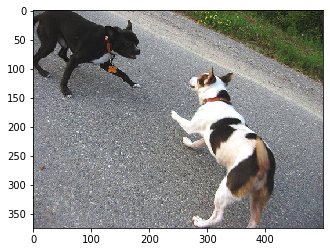

In [ ]:
str=generate_caption("1001773457_577c3a7d70.jpg")

---------------------Actual---------------------
little girl covered in paint sits in front of painted rainbow with her hands in bowl
little girl is sitting in front of large painted rainbow
small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it
there is girl with pigtails sitting in front of rainbow painting
young girl with pigtails painting outside in the grass
--------------------Predicted--------------------
two children in red dresses and red coats are playing on the ground


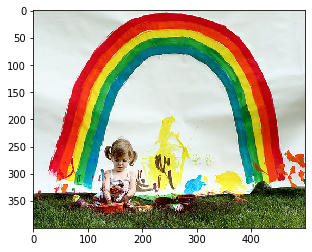

In [ ]:
str=generate_caption("1002674143_1b742ab4b8.jpg")

---------------------Actual---------------------
man in hat is displaying pictures next to skier in blue hat
man skis past another man displaying paintings in the snow
person wearing skis looking at framed pictures set up in the snow
skier looks at framed pictures in the snow next to trees
man on skis looking at artwork for sale in the snow
--------------------Predicted--------------------
two skiers skiing in snow


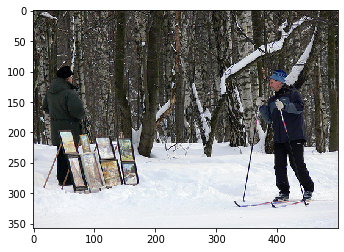

In [ ]:
str=generate_caption("101669240_b2d3e7f17b.jpg")

---------------------Actual---------------------
brown dog chases the water from sprinkler on lawn
brown dog plays with the hose
brown dog running on lawn near garden hose
dog is playing with hose
large brown dog running away from the sprinkler in the grass
--------------------Predicted--------------------
brown dog is running through grassy yard


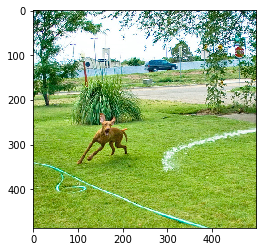

In [ ]:
str=generate_caption("1019077836_6fc9b15408.jpg")


In [ ]:
print(str)

brown dog is running through grassy yard


In [ ]:
from gtts import gTTS
def gen_audio(mytext):
    audio = gTTS(text=mytext, lang="en", slow=False)
    audio.save("example.mp3")
    os.system("start example.mp3")

In [ ]:
gen_audio(str)

2872197070_4e97c3ccfa
~~~~~~~~~~~~Actual~~~~~~~~~~~~~~
startseq white dog is leaping into swimming pool endseq
startseq white dog jumping into pool endseq
startseq white dog jumps into pool endseq
startseq white dog jumps into swimming pool endseq
startseq the white dog jumps into the blue pool endseq
~~~~~~~~~~~~Predicted~~~~~~~~~~~
white dog jumps into pool


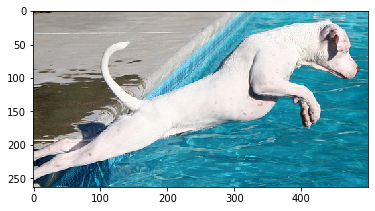

In [ ]:
str=generate_random_caption()

In [ ]:
English2Braiile(str)

'⠺⠓⠊⠞⠑⠀⠙⠕⠛⠀⠚⠥⠍⠏⠎⠀⠊⠝⠞⠕⠀⠏⠕⠕⠇'

brown and white dog is walking through the snow


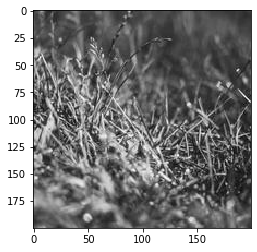

In [ ]:
str=generate_new_caption()

---------------------Actual---------------------
black dog and spotted dog are fighting
black dog and tri-colored dog playing with each other on the road
black dog and white dog with brown spots are staring at each other in the street
two dogs of different breeds looking at each other on the road
two dogs on pavement moving toward each other
--------------------Predicted--------------------
two dogs playing with each other on the ground


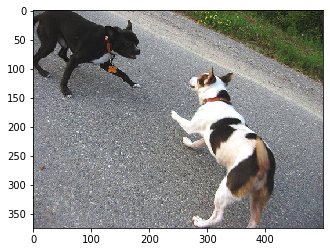

In [ ]:
str=generate_caption("1001773457_577c3a7d70.jpg")

In [ ]:
str

'two dogs playing with each other on the ground'

---------------------Actual---------------------
man in hat is displaying pictures next to skier in blue hat
man skis past another man displaying paintings in the snow
person wearing skis looking at framed pictures set up in the snow
skier looks at framed pictures in the snow next to trees
man on skis looking at artwork for sale in the snow
--------------------Predicted--------------------
two skiers skiing in snow


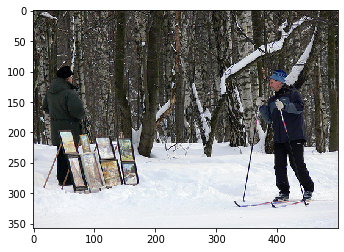

In [ ]:
str=generate_caption("101669240_b2d3e7f17b.jpg")

In [ ]:
str

'two skiers skiing in snow'

In [ ]:
gen_audio(str)

3561130207_d1ed166daa
~~~~~~~~~~~~Actual~~~~~~~~~~~~~~
startseq crowd of girls at concert endseq
startseq crowd of people stand endseq
startseq adoring girls watch the singer at the concert endseq
startseq group of people smiling and dancing in huddle group together endseq
startseq "a large group of people are watching something screaming and taking pictures ." endseq
~~~~~~~~~~~~Predicted~~~~~~~~~~~
group of people are gathered in huddle with color covering


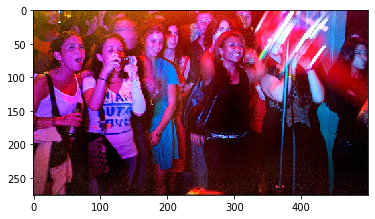

In [ ]:
str=generate_random_caption()

In [ ]:
str

'group of people are gathered in huddle with color covering'

In [ ]:
gen_audio(str)

In [ ]:
English2Braiile(str)

'⠛⠗⠕⠥⠏⠀⠕⠋⠀⠏⠑⠕⠏⠇⠑⠀⠁⠗⠑⠀⠛⠁⠞⠓⠑⠗⠑⠙⠀⠊⠝⠀⠓⠥⠙⠙⠇⠑⠀⠺⠊⠞⠓⠀⠉⠕⠇⠕⠗⠀⠉⠕⠧⠑⠗⠊⠝⠛'

254475194_3d8f4dfd53
~~~~~~~~~~~~Actual~~~~~~~~~~~~~~
startseq black dog runs in grassy yard while woman dressed in green watches from in fton of tan house endseq
startseq black dog runs in yard while woman observes endseq
startseq dog and master play in grassy residential backyard endseq
startseq man is watching his dog in his yard endseq
startseq woman and dog standing in the grass endseq
~~~~~~~~~~~~Predicted~~~~~~~~~~~
two dogs are running along grassy field


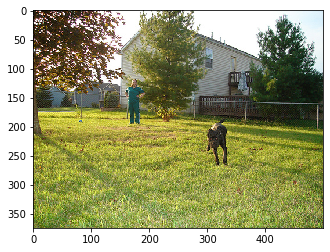

In [ ]:
str=generate_random_caption()

In [ ]:
str

'two dogs are running along grassy field'

In [ ]:
gen_audio(str)

In [ ]:
English2Braiile(str)

'⠞⠺⠕⠀⠙⠕⠛⠎⠀⠁⠗⠑⠀⠗⠥⠝⠝⠊⠝⠛⠀⠁⠇⠕⠝⠛⠀⠛⠗⠁⠎⠎⠽⠀⠋⠊⠑⠇⠙'

person is climbing cliff overlooking the water


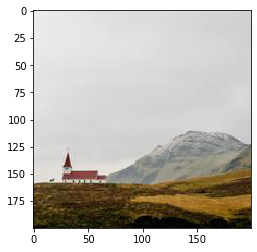

In [ ]:
str=generate_new_caption()

In [ ]:
str

'person is climbing cliff overlooking the water'

In [ ]:
gen_audio(str)

In [ ]:
English2Braiile(str)

'⠏⠑⠗⠎⠕⠝⠀⠊⠎⠀⠉⠇⠊⠍⠃⠊⠝⠛⠀⠉⠇⠊⠋⠋⠀⠕⠧⠑⠗⠇⠕⠕⠅⠊⠝⠛⠀⠞⠓⠑⠀⠺⠁⠞⠑⠗'

man is walking in the middle of the ocean


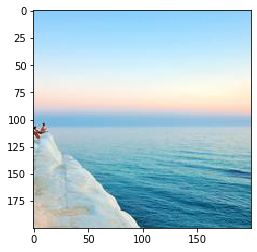

In [ ]:
str=generate_new_caption()

In [ ]:
str

'man is walking in the middle of the ocean'

In [ ]:
gen_audio(str)

In [ ]:
English2Braiile(str)

'⠍⠁⠝⠀⠊⠎⠀⠺⠁⠇⠅⠊⠝⠛⠀⠊⠝⠀⠞⠓⠑⠀⠍⠊⠙⠙⠇⠑⠀⠕⠋⠀⠞⠓⠑⠀⠕⠉⠑⠁⠝'